# Assignment 1

This notebook is for Unit tests.

## 1 Import project modules

In [1]:
import models
import data_loader
import strategies
import engine
import reporting

## 2 Unit test

These checks validate:
- CSV parsing into frozen dataclass
- Mutable behavior of Order
- Exception raising and handling

In [2]:
from dataclasses import FrozenInstanceError
from datetime import datetime
from pathlib import Path

def run_unit_checks() -> None:
    # Check 1: CSV parsing 
    csv_path = Path("market_data.csv")
    assert csv_path.exists(), "market_data.csv not found in week1/"

    ticks = data_loader.load_data(str(csv_path))
    assert isinstance(ticks, list)
    assert len(ticks) > 0
    assert isinstance(ticks[0], models.MarketDataPoint)

    # Check 2: MarketDataPoint is frozen (cannot mutate price)
    mdp = models.MarketDataPoint(timestamp=datetime.now(), symbol="AAPL", price=123.45)
    try:
        mdp.price = 999.0
        raise AssertionError("MarketDataPoint.price should be immutable, but mutation succeeded.")
    except FrozenInstanceError:
        pass

    # Check 3: Order is mutable (status can be updated)
    o = models.Order(symbol="AAPL", quantity=1, price=100.0, status="NEW")
    o.status = "FILLED"
    assert o.status == "FILLED"

    # Check 4: Invalid order raises OrderError
    try:
        bad = models.Order(symbol="AAPL", quantity=0, price=100.0, status="NEW")
        bad.validate()
        raise AssertionError("Expected OrderError for quantity<=0")
    except models.OrderError:
        pass

    # Check 5: ExecutionError can happen but engine continues
    # Use a guaranteed failure rate so at least one ExecutionError is logged.
    strat = strategies.Momentum(lookback=1, qty=1)
    eng = engine.Engine(
        strategies=[strat],
        default_qty=1,
        fail_rate=1.0,
        seed=1,
        initial_cash=1000.0,
    )

    # Minimal synthetic ticks
    data = [
        models.MarketDataPoint(datetime(2026, 1, 1, 9, 30, 0), "AAPL", 100.0),
        models.MarketDataPoint(datetime(2026, 1, 1, 9, 31, 0), "AAPL", 101.0),
    ]
    eng.run(data)

    assert len(eng.equity_curve) == 2, "Engine should continue and record equity curve even on failures"
    assert any("ExecutionError" in e or "Simulated execution failure" in e for e in eng.errors), "Expected an execution failure logged"

    print("All unit checks passed.")


run_unit_checks()


All unit checks passed.


## 3 Run the backtest

In [3]:
from pathlib import Path

csv_path = Path("market_data.csv")
data = data_loader.load_data(str(csv_path))

# Instantiate two concrete strategies
mac = strategies.MAC(short_win=5, long_win=20)
mom = strategies.Momentum(lookback=5)

# Create engine
eng = engine.Engine(
    strategies=[mac, mom],
    default_qty=1,
    fail_rate=0.02,
    seed=42,
    initial_cash=100000.0,
)

# Run
eng.run(data)

print("Backtest complete")
print("Ticks processed:", len(data))
print("Equity points:", len(eng.equity_curve))
print("Errors logged:", len(eng.errors))
print("Positions:", eng.positions)
print("Cash:", eng.cash)

Backtest complete
Ticks processed: 500
Equity points: 500
Errors logged: 50
Positions: {'AAPL': {'quantity': 88, 'avg_price': 154.24303810702904}}
Cash: 87302.72000000009


## 4 total return, periodic returns, Sharpe ratio, max drawdown

In [4]:
metrics = reporting.compute_metrics(eng.equity_curve)
metrics


{'total_return': 0.030767200000000994,
 'returns': [0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  -3.1000000001446537e-06,
  -2.7400084940287783e-05,
  9.100277558404812e-06,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  -2.7400586372405833e-05,
  0.0,
  1.500073203652974e-06,
  0.0,
  1.8700884552025343e-05,
  3.640104106983344e-05,
  1.1699908740725462e-05,
  -0.0001403972622534555,
  -0.00017252085777175186,
  1.4004108805476534e-05,
  3.15088035598432e-05,
  4.581135663528357e-05,
  -7.001414986662624e-07,
  2.860580125663148e-05,
  -3.9906951791013334e-05,
  3.960848017570129e-05,
  1.0001745303078735e-06,
  5.400937062471911e-06,
  -0.00021073542462479722,
  -6.782569237229197e-05,
  -0.00010654758415107324,
  8.13449919150333e-05,
  -5.9227943744022404e-05,
  8.404462769728838e-06,
  0.0,
  0.0,
  -4.032107179208211e-05,
  0.0,
  -4.002252869117484e-07,
  0.0,
  -4.7126546383502443e-05,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  -3.251985011654135e-05,
  0.0,
  0.0,
  0.0,
  0

## 5 Display summary table

In [5]:
import pandas as pd

summary_df = pd.DataFrame([
    {"metric": "start_equity", "value": metrics.get("start_equity", None)},
    {"metric": "end_equity", "value": metrics.get("end_equity", None)},
    {"metric": "total_return", "value": metrics.get("total_return", None)},
    {"metric": "sharpe", "value": metrics.get("sharpe", None)},
    {"metric": "max_drawdown", "value": metrics.get("max_drawdown", None)},
])
summary_df


,metric,value
0,start_equity,100000.000000
1,end_equity,103076.720000
2,total_return,0.030767
3,sharpe,0.640823
4,max_drawdown,-0.032209


## 6 Plot equity curve

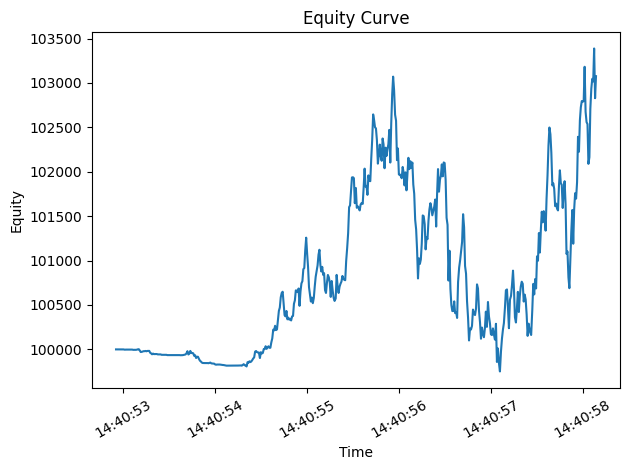

In [6]:
import matplotlib.pyplot as plt

ts = [x[0] for x in eng.equity_curve]
eq = [x[1] for x in eng.equity_curve]

plt.figure()
plt.plot(ts, eq)
plt.title("Equity Curve")
plt.xlabel("Time")
plt.ylabel("Equity")
plt.xticks(rotation=30)
plt.tight_layout()
plt.show()

## 7 Preview narrative

In [7]:
from itertools import islice

out_md = Path("performance.md")
reporting.write_report(str(out_md), metrics, eng.equity_curve, eng.errors)
print("Wrote:", out_md.resolve())

with open("performance.md", "r", encoding="utf-8") as f:
    preview = list(islice(f, 80))

print("".join(preview))

Wrote: C:\Users\xouya\Desktop\uchicago\FINM32500\week1\performance.md
# Performance Report

## Summary Metrics

| Metric | Value |
|---|---:|
| Start Equity | 100,000.00 |
| End Equity | 103,076.72 |
| Total Return | 0.0308 |
| Sharpe Ratio | 0.6408 |
| Max Drawdown | -0.0322 |

## Equity Curve (ASCII)

```
                                    *                       
                                  **                        
                                           *                
                               * *   **                 *   
                                *      * **              ** 
                                                            
                         *              *              *    
                           *  *              *             *
                          * **                       *      
                      ***                   * **   ** *     
                    **                          **          
********************